# Wines Points prediction 

In [69]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

In [71]:
from sklearn.preprocessing import Normalizer

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yarden.ayalon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yarden.ayalon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yarden.ayalon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [77]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [78]:
#pip install cufflinks

In [79]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [80]:
import plotly.express as px

In [81]:
import string

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [82]:
import pandas as pd
#import cufflinks as cf; cf.go_offline()

In [83]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

### First glace on the data

In [84]:
wine_reviews.head(10)

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   
5           5     Spain  Blackberry and raspberry aromas show a typical...   
6           6     Italy  Here's a bright, informal red that opens with ...   
7           7    France  This dry and restrained wine offers spice in p...   
8           8   Germany  Savory dried thyme notes accent sunnier flavor...   
9           9    France  This has great depth of flavor with its fresh ...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   
5                        Ars In Vitro      87   15.0     Northern Spain   
6                             Belsito      87   16.0  Sicily & Sardinia   
7                                 NaN      87   24.0             Alsace   
8                               Shine      87   12.0        Rheinhessen   
9                         Les Natures      87   27.0             Alsace   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   
5              Navarra                NaN   Michael Schachner   
6             Vittoria                NaN       Kerin O’Keefe   
7               Alsace                NaN          Roger Voss   
8                  NaN                NaN  Anna Lee C. Iijima   
9               Alsace                NaN          Roger Voss   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   
5           @wineschach  Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...   
6          @kerinokeefe   Terre di Giurfo 2013 Belsito Frappato (Vittoria)   
7            @vossroger              Trimbach 2012 Gewurztraminer (Alsace)   
8                   NaN  Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...   
9            @vossroger  Jean-Baptiste Adam 2012 Les Natures Pinot Gris...   

              variety               winery  
0         White Blend              Nicosia  
1      Portuguese Red  Quinta dos Avidagos  
2          Pinot Gris            Rainstorm  
3            Riesling           St. Julian  
4          Pinot Noir         Sweet Cheeks  
5  Tempranillo-Merlot               Tandem  
6            Frappato      Terre di Giurfo  
7      Gewürztraminer             Trimbach  
8      Gewürztraminer          Heinz Eifel  
9          Pinot Gris   Jean-Baptiste Adam

## Dropping duplications

In [85]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [86]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

## Data info

In [87]:
wine_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


In [88]:
##some of the columns contains null values

## Is title unique - ?

In [89]:
wine_reviews.title.value_counts().head()

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                9
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)               7
Segura Viudas NV Extra Dry Sparkling (Cava)                           7
Bailly-Lapierre NV Brut  (Crémant de Bourgogne)                       6
J Vineyards & Winery NV Brut Rosé Sparkling (Russian River Valley)    6
Name: title, dtype: int64

In [90]:
# we should take it into considiration when running the models 

In [91]:
# Looking to see if the same title has same descriptions/other attributes ? 

In [92]:
wine_reviews[wine_reviews.title == wine_reviews.title.value_counts().idxmax()]

country                                        description  \
3209        US  Creamy, lush and somewhat robust, this dry spa...   
4399        US  Made predominantly from Pinot Noir, this is an...   
27773       US  A wonderfully drinkable sparkling wine that ap...   
63179       US  Made from mostly Pinot Noir grapes, with an ad...   
81563       US  This wine shows lots of finesse for the price....   
94321       US  A bit rough and scouring in texture, this tast...   
100738      US  A good, dry and elegant bubbly. Shows crisp fl...   
109001      US  From almost 92% Pinot Noir with the remainder ...   
122208      US  This bubbly is rich in cherry and raspberry fr...   

        designation  points  price    province       region_1 region_2  \
3209    Sonoma Brut      90   22.0  California  Sonoma County   Sonoma   
4399    Sonoma Brut      88   22.0  California  Sonoma County   Sonoma   
27773   Sonoma Brut      90   20.0  California  Sonoma County   Sonoma   
63179   Sonoma Brut      92   22.0  California  Sonoma County   Sonoma   
81563   Sonoma Brut      89   24.0  California  Sonoma County   Sonoma   
94321   Sonoma Brut      85   20.0  California  Sonoma County   Sonoma   
100738  Sonoma Brut      89   20.0  California  Sonoma County   Sonoma   
109001  Sonoma Brut      88   22.0  California  Sonoma County   Sonoma   
122208  Sonoma Brut      86   20.0  California  Sonoma County   Sonoma   

           taster_name taster_twitter_handle  \
3209    Virginie Boone               @vboone   
4399    Virginie Boone               @vboone   
27773              NaN                   NaN   
63179   Virginie Boone               @vboone   
81563              NaN                   NaN   
94321              NaN                   NaN   
100738             NaN                   NaN   
109001  Virginie Boone               @vboone   
122208             NaN                   NaN   

                                                    title          variety  \
3209    Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
4399    Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
27773   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
63179   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
81563   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
94321   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
100738  Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
109001  Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
122208  Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   

               winery  
3209    Gloria Ferrer  
4399    Gloria Ferrer  
27773   Gloria Ferrer  
63179   Gloria Ferrer  
81563   Gloria Ferrer  
94321   Gloria Ferrer  
100738  Gloria Ferrer  
109001  Gloria Ferrer  
122208  Gloria Ferrer

In [93]:
# Looks like that the de-duping was good

### EDA

### Get to know Point attribute 

In [94]:
wine_reviews.points.describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

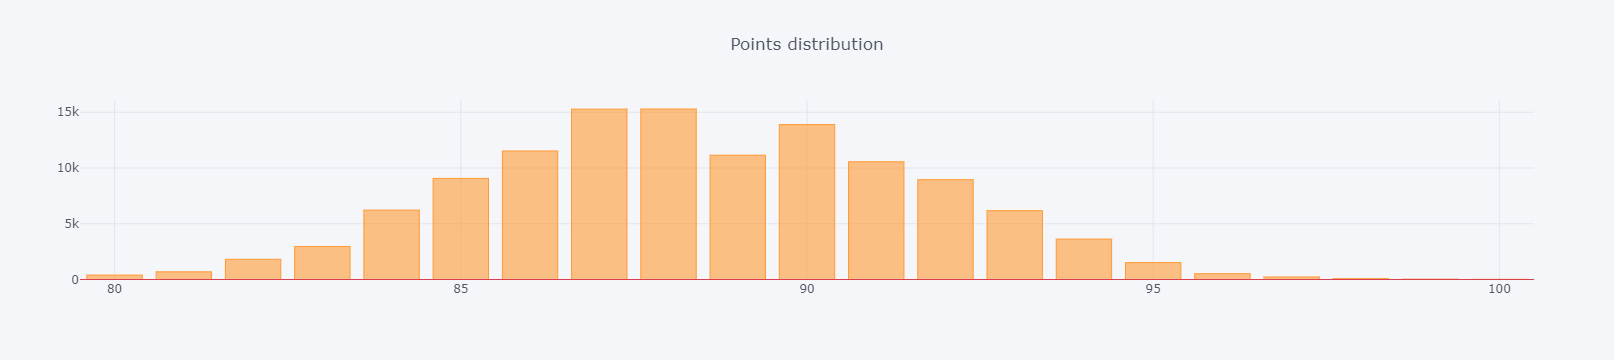

In [95]:
wine_reviews.points.value_counts().iplot(kind='bar', title = 'Points distribution', hline=(0))

In [96]:
# Nice distribution of the points, no speacial treat is needed here 

### Country

In [97]:
pd.concat([wine_reviews.country.value_counts().rename('counts'), 
          wine_reviews.country.value_counts().rename('proportion').div(wine_reviews.shape[0])], axis=1).head()

counts  proportion
US         50457    0.420517
France     20353    0.169625
Italy      17940    0.149515
Spain       6116    0.050972
Portugal    5256    0.043804

In [98]:
### Connection between price and points

In [99]:
def calc_average_score_and_price(country_df):
    return pd.Series({'average_price': country_df.price.mean(),
                      'average_score': country_df.points.mean()})

In [100]:
stats_by_country = wine_reviews.groupby('country').apply(calc_average_score_and_price)
stats_by_country.head()

average_price  average_score
country                                             
Argentina                   24.575264      86.649831
Armenia                     14.500000      87.500000
Australia                   35.686491      88.561220
Austria                     31.336751      90.129532
Bosnia and Herzegovina      12.500000      86.500000

In [101]:
stats_by_country.average_score.sort_values(ascending=False).head(20).iplot(kind='bar', title = 'Wine scores by country (Sorted)')

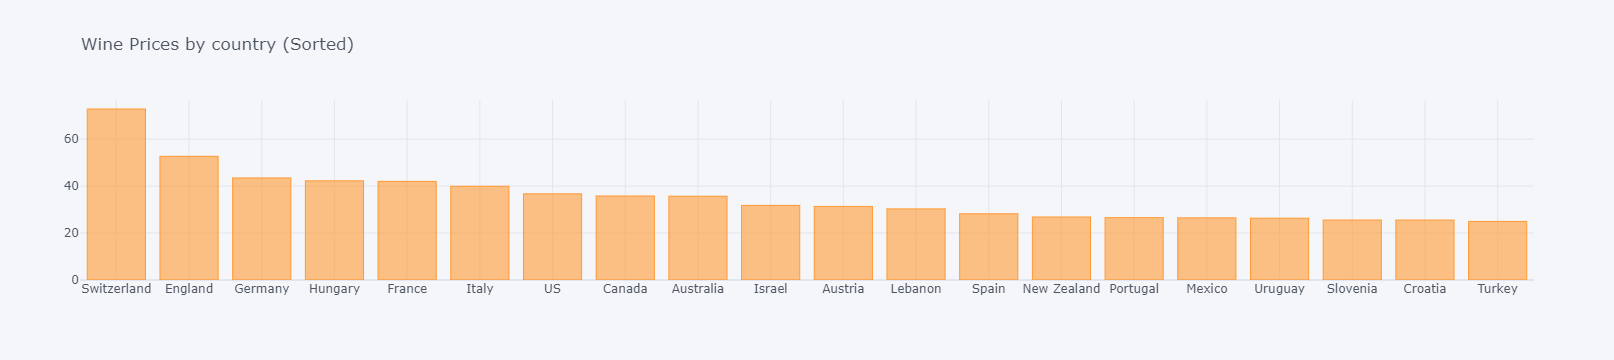

In [102]:
stats_by_country.average_price.sort_values(ascending=False).head(20).iplot(kind='bar', title = 'Wine Prices by country (Sorted)')

### Correlation between price and score 

In [103]:
wine_reviews[['price','points']].corr(method = 'pearson')

price    points
price   1.000000  0.416534
points  0.416534  1.000000

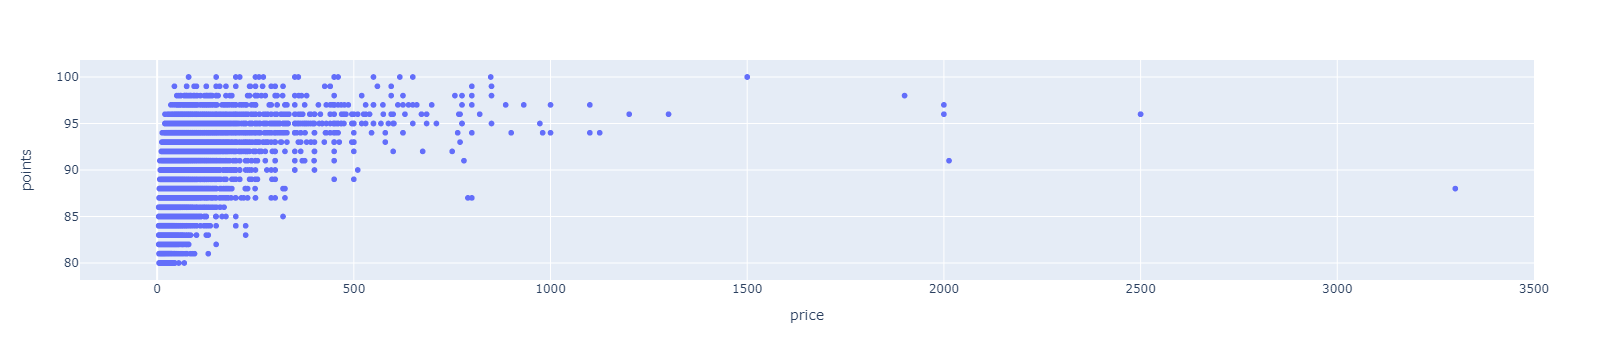

In [104]:
px.scatter(wine_reviews, x="price", y="points")

In [105]:
top_ten_countries = wine_reviews.country.value_counts().index[:10]
list(top_ten_countries)

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany']

In [106]:
wine_reviews.groupby('country')[['price','points']].corr(method = 'pearson').loc[top_ten_countries]

price    points
country                             
US        price   1.000000  0.455320
          points  0.455320  1.000000
France    price   1.000000  0.406553
          points  0.406553  1.000000
Italy     price   1.000000  0.531854
          points  0.531854  1.000000
Spain     price   1.000000  0.478852
          points  0.478852  1.000000
Portugal  price   1.000000  0.438125
          points  0.438125  1.000000
Chile     price   1.000000  0.482639
          points  0.482639  1.000000
Argentina price   1.000000  0.571894
          points  0.571894  1.000000
Austria   price   1.000000  0.391295
          points  0.391295  1.000000
Australia price   1.000000  0.468471
          points  0.468471  1.000000
Germany   price   1.000000  0.457733
          points  0.457733  1.000000

In [107]:
wine_reviews

country                                        description  \
0          Italy  Aromas include tropical fruit, broom, brimston...   
1       Portugal  This is ripe and fruity, a wine that is smooth...   
2             US  Tart and snappy, the flavors of lime flesh and...   
3             US  Pineapple rind, lemon pith and orange blossom ...   
4             US  Much like the regular bottling from 2012, this...   
...          ...                                                ...   
129966   Germany  Notes of honeysuckle and cantaloupe sweeten th...   
129967        US  Citation is given as much as a decade of bottl...   
129968    France  Well-drained gravel soil gives this wine its c...   
129969    France  A dry style of Pinot Gris, this is crisp with ...   
129970    France  Big, rich and off-dry, this is powered by inte...   

                                   designation  points  price  \
0                                 Vulkà Bianco      87    NaN   
1                                     Avidagos      87   15.0   
2                                          NaN      87   14.0   
3                         Reserve Late Harvest      87   13.0   
4           Vintner's Reserve Wild Child Block      87   65.0   
...                                        ...     ...    ...   
129966  Brauneberger Juffer-Sonnenuhr Spätlese      90   28.0   
129967                                     NaN      90   75.0   
129968                                   Kritt      90   30.0   
129969                                     NaN      90   32.0   
129970           Lieu-dit Harth Cuvée Caroline      90   21.0   

                 province             region_1           region_2  \
0       Sicily & Sardinia                 Etna                NaN   
1                   Douro                  NaN                NaN   
2                  Oregon    Willamette Valley  Willamette Valley   
3                Michigan  Lake Michigan Shore                NaN   
4                  Oregon    Willamette Valley  Willamette Valley   
...                   ...                  ...                ...   
129966              Mosel                  NaN                NaN   
129967             Oregon               Oregon       Oregon Other   
129968             Alsace               Alsace                NaN   
129969             Alsace               Alsace                NaN   
129970             Alsace               Alsace                NaN   

               taster_name taster_twitter_handle  \
0            Kerin O’Keefe          @kerinokeefe   
1               Roger Voss            @vossroger   
2             Paul Gregutt           @paulgwine    
3       Alexander Peartree                   NaN   
4             Paul Gregutt           @paulgwine    
...                    ...                   ...   
129966  Anna Lee C. Iijima                   NaN   
129967        Paul Gregutt           @paulgwine    
129968          Roger Voss            @vossroger   
129969          Roger Voss            @vossroger   
129970          Roger Voss            @vossroger   

                                                    title         variety  \
0                       Nicosia 2013 Vulkà Bianco  (Etna)     White Blend   
1           Quinta dos Avidagos 2011 Avidagos Red (Douro)  Portuguese Red   
2           Rainstorm 2013 Pinot Gris (Willamette Valley)      Pinot Gris   
3       St. Julian 2013 Reserve Late Harvest Riesling ...        Riesling   
4       Sweet Cheeks 2012 Vintner's Reserve Wild Child...      Pinot Noir   
...                                                   ...             ...   
129966  Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...        Riesling   
129967                  Citation 2004 Pinot Noir (Oregon)      Pinot Noir   
129968  Domaine Gresser 2013 Kritt Gewurztraminer (Als...  Gewürztraminer   
129969      Domaine Marcel Deiss 2012 Pinot Gris (Alsace)      Pinot Gris   
129970  Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...  Gewürztraminer 

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [108]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [109]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [111]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [112]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.616438
MAE    2.532518
R2    -0.000004
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [113]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.579761
Armenia                   87.500000
Australia                 88.484866
Austria                   90.112536
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [114]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.139335
MAE    2.466153
R2     0.049610
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [115]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.716455
           Other               85.765281
Armenia    Armenia             87.500000
Australia  Australia Other     85.420765
           New South Wales     87.635135
Name: basiline_3_predicted_points, dtype: float64

In [116]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [117]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.606235
MAE    2.374991
R2     0.105046
dtype: float64

### Baselines summary

In [118]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

MSE       MAE        R2
baseline_1  9.616438  2.532518 -0.000004
baseline_2  9.139335  2.466153  0.049610
baseline_3  8.606235  2.374991  0.105046

In [119]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [120]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
le = LabelEncoder()
scalar=StandardScaler()

#### Preparing data - Lable encoding categorical features

In [121]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [122]:
wine_reviews[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      119929 non-null  object
 1   province     119929 non-null  object
 2   region_1     100428 non-null  object
 3   region_2     46769 non-null   object
 4   taster_name  95071 non-null   object
 5   variety      119987 non-null  object
 6   winery       119988 non-null  object
dtypes: object(7)
memory usage: 7.3+ MB


In [123]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

country  province  region_1  region_2  taster_name  variety  winery  price  \
0       22       332       424         6            9      691   11608   -1.0   
1       32       108       738         6           16      451   12956   15.0   
2       41       269      1218        17           15      437   13018   14.0   
3       41       218       549         6            0      480   14390   13.0   
4       41       269      1218        17           15      441   14621   65.0   

   points  
0      87  
1      87  
2      87  
3      87  
4      87

In [124]:
#scalar.fit_transform(train_encoded_features[categorical_features])

#### Re-splitting to train and test

In [125]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))
test_encoded_features

country  province  region_1  region_2  taster_name  variety  winery  \
3            41       218       549         6            0      480   14390   
7            15        11        21         6           16      209   15395   
8            17       308       738         6            1      209    8415   
9            15        11        21         6           16      437    8989   
11           15        11        21         6           16      209    9963   
...         ...       ...       ...       ...          ...      ...     ...   
129950       41        51       747         7           19      703    8429   
129953       30       148       738         6            8       77   11099   
129958       30       148       738         6            8       62     883   
129961       22       332       992         6            9      186    1898   
129969       15        11        21         6           16      437    6027   

        price  points  
3        13.0      87  
7        24.0      87  
8        12.0      87  
9        27.0      87  
11       30.0      87  
...       ...     ...  
129950   35.0      90  
129953   25.0      90  
129958   35.0      90  
129961   30.0      90  
129969   32.0      90  

[23998 rows x 9 columns]

###  Playing around with standartization

In [126]:
# Testing standartization
# encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
# encoded_features=scalar.fit_transform(encoded_features)
# encoded_features = pd.DataFrame(encoded_features, columns = ['country','province','region_1','region_2','taster_name','variety','winery'])
# encoded_features

In [127]:
#Standartizing categorial features to fit best for the linear model

In [128]:
# train_encoded_features = train_encoded_features[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
# train_encoded_features=scalar.fit_transform(train_encoded_features)
# train_encoded_features = pd.DataFrame(train_encoded_features, columns = ['country','province','region_1','region_2','taster_name','variety','winery'])
# # train_encoded_features['price'] = wine_reviews.price
# # train_encoded_features['points'] = wine_reviews.points


In [129]:
#train_encoded_features.info()

In [130]:
# test_encoded_features = test_encoded_features[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
# test_encoded_features=scalar.fit_transform(test_encoded_features)
# test_encoded_features = pd.DataFrame(test_encoded_features, columns = ['country','province','region_1','region_2','taster_name','variety','winery'])
# # test_encoded_features['price'] = wine_reviews.price.fillna(-1)
# # test_encoded_features['points'] = wine_reviews.points
# # test_encoded_features

In [131]:
#test_encoded_features.info()

#### Fitting a tree-regressor

In [132]:
from src.models import i_feel_lucky_xgboost_training

In [133]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [134]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [135]:
test_encoded_features.head()

country  province  region_1  region_2  taster_name  variety  winery  \
3        41       218       549         6            0      480   14390   
7        15        11        21         6           16      209   15395   
8        17       308       738         6            1      209    8415   
9        15        11        21         6           16      437    8989   
11       15        11        21         6           16      209    9963   

    price  points  xgb_clf_points_prediction  
3    13.0      87                         86  
7    24.0      87                         88  
8    12.0      87                         87  
9    27.0      87                         88  
11   30.0      87                         88

In [136]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.450496
MAE    1.923952
R2     0.329219
dtype: float64

In [137]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

MSE       MAE        R2
baseline_1         9.616438  2.532518 -0.000004
baseline_2         9.139335  2.466153  0.049610
baseline_3         8.606235  2.374991  0.105046
regression_by_xgb  6.450496  1.923952  0.329219

In [138]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

To be implemende by you.

In [139]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")


### Removing stop words and punctuation

In [140]:
all_test_words = [word.lower() for description in train_data.description for word in nltk.word_tokenize(description) if word.lower() not in stopwords and word not in string.punctuation ] # Words without stop words


### Creating vocabulary only from train data

In [141]:
words_df = pd.DataFrame(data = all_test_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head(10)

word  wordCount  wordImportance
0     wine      59290        0.000012
1  flavors      46283        0.000015
2       's      38302        0.000018
3    fruit      33183        0.000021
4   aromas      28897        0.000024
5   palate      27859        0.000025
6   finish      25750        0.000027
7  acidity      25664        0.000027
8  tannins      22751        0.000030
9    drink      22078        0.000031

In [142]:
print("Total of {} words, {} unique words".format(len(all_test_words), len(words_df)))

Total of 2428763 words, 41081 unique words


In [143]:
print ("Using words with 10 or more appearnces will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 10)))

Using words with 10 or more appearnces will reduce the corpus size to: 8319


### Choosing only words that appear at least 10 times - This is probably not the best approach since this domain might have less frequent words with lots of meaning and impact

In [144]:
words_df = words_df[words_df.wordCount >= 10]

### Using only description column - Words represented as Bag of words (One-hot-encoding)

In [145]:
clean_vocab = set(words_df.word)
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
clean_bow_counts = count_vect.fit_transform(train_data.description)
clean_bow_counts.shape

(95990, 8319)

### Using train BOW to run a CV on it and find optimal alpha

In [146]:
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
mse_by_alpha = []
for alpha in search_grid:
    model = Ridge( alpha=alpha)
    avg_score = abs(cross_val_score(model, clean_bow_counts, y =train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean())
    mse_by_alpha.append((alpha,avg_score))

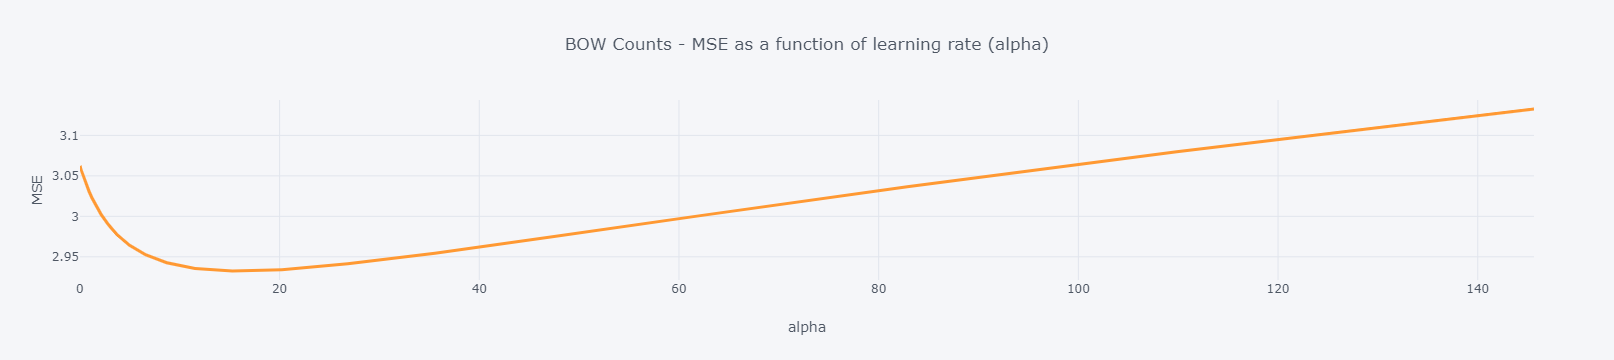

In [147]:
cv_results = pd.DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 150').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [148]:
cv_results.sort_values(by='MSE').head(10)

alpha       MSE
26  15.264180  2.932476
27  20.235896  2.934110
25  11.513954  2.935620
28  26.826958  2.941320
24   8.685114  2.942731
23   6.551286  2.952671
29  35.564803  2.954437
22   4.941713  2.964461
30  47.148664  2.974345
21   3.727594  2.977244

In [149]:
# opt_alpha, max_auc = cv_results.loc[cv_results.MSE.idxmin()]
# print(opt_alpha, max_auc)

In [150]:
opt_alpha, max_auc = cv_results.loc[cv_results.MSE.idxmin()]
print(opt_alpha, max_auc)

15.264179671752334 2.9324755400348668


In [151]:
model = Ridge( alpha=opt_alpha)
#model = Ridge( alpha=15.264179671752334)
model.fit(clean_bow_counts, train_data.points)

Ridge(alpha=15.264179671752334)

In [152]:
###Creating test BOW

In [153]:
clean_bow_counts_test = count_vect.fit_transform(test_data.description)

In [154]:
test_data['predicted_score']= model.predict(clean_bow_counts_test)

In [155]:
b4_stats = calc_prediction_quality(test_data, 'predicted_score', 'points')
b4_stats

MSE    2.928836
MAE    1.346959
R2     0.695433
dtype: float64

### Ways of improving this part - Enlarge the vocabulary to have less frequent words. 
### It seems that the model used it capacity as the train MSE lowers and then going back up

### Using only description column + other features - Words represented as Bag of words (One-hot-encoding)

### Creating sparse matrix for BOW + Features

In [163]:
from scipy.sparse import coo_matrix, hstack

train_features_spares_matrix = coo_matrix(train_encoded_features.iloc[:,0:8])
train_united_features = hstack((clean_bow_counts ,train_features_spares_matrix))

test_features_spares_matrix = coo_matrix(test_encoded_features.iloc[:,0:8])
test_united_features = hstack((clean_bow_counts_test ,test_features_spares_matrix))

In [164]:
%%capture
#search_grid = np.logspace(-2, 3, num=30, endpoint=True, base=10.0)
search_grid=[0.001,0.01,0.1,0,1,5,15,50,100,1000]
#search_grid=[0.01,15]
auc_by_alpha = []
for alpha in search_grid:
    model = Ridge( alpha=alpha,tol=0.00001)
    #model = Ridge( alpha=alpha,max_iter=10000,tol=0.00001)
    avg_score = abs(cross_val_score(model, train_united_features, y =train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean())
    auc_by_alpha.append((alpha,avg_score))

In [165]:
auc_by_alpha

[(0.001, 3.0647321998504964),
 (0.01, 3.0647593191737355),
 (0.1, 3.060885684838335),
 (0, 3.065069009968181),
 (1, 3.0300104423896697),
 (5, 2.9645537067056145),
 (15, 2.9327815518391396),
 (50, 2.9795238613293273),
 (100, 3.0646722001763966),
 (1000, 3.8102291006020095)]

In [166]:
#@help(cv_results.iplot)

In [167]:
#auc_by_alpha - >After standartizing results

In [168]:
import plotly_express as px

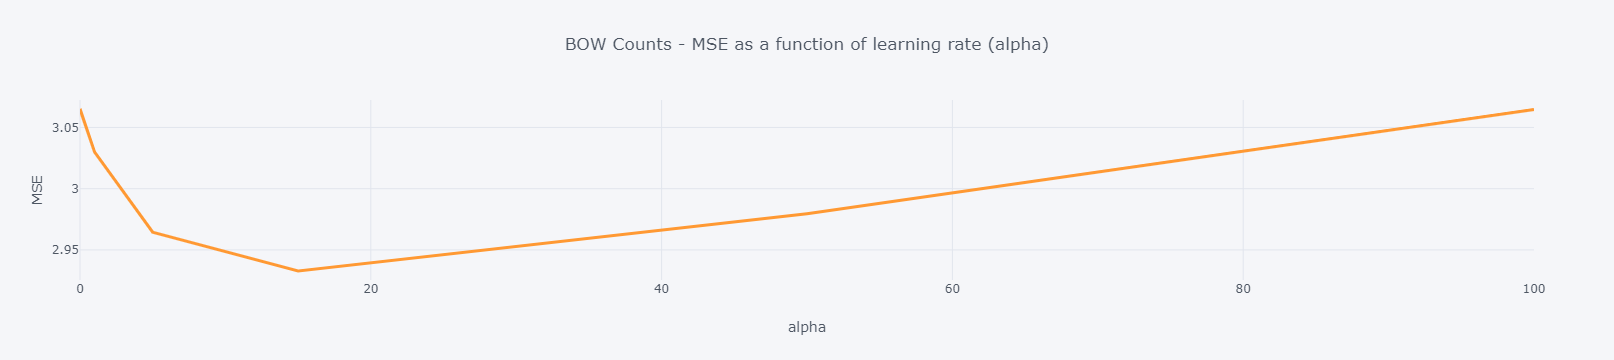

AttributeError: 'NoneType' object has no attribute 'update_layout'

In [169]:
cv_results = pd.DataFrame(auc_by_alpha, columns = ['alpha', 'MSE'])
fig=cv_results.query('alpha <= 100').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))
fig.update_layout( xaxis_type="log")

In [ ]:
#Dont TOUCH!
# opt_alpha, min_mce = cv_results.loc[cv_results.MSE.idxmin()]
# print(opt_alpha, min_mce)

In [170]:
#Old model - without stadartizing categorail features
opt_alpha, min_mce = cv_results.loc[cv_results.MSE.idxmin()]
print(opt_alpha, min_mce)

15.0 2.9327815518391396


In [171]:
model = Ridge( alpha=opt_alpha,max_iter=10000,tol=0.00001)
#model = Ridge( alpha=15.264179671752334,max_iter=10000,tol=0.00001)
#model = Ridge( alpha=11.5)
model.fit(train_united_features, train_data.points)

Ridge(alpha=15.0, max_iter=10000, tol=1e-05)

In [172]:
test_data['predicted_score_by_both']= model.predict(test_united_features)

In [173]:
b5_stats = calc_prediction_quality(test_data, 'predicted_score_by_both', 'points')
b5_stats

MSE    2.931953
MAE    1.347717
R2     0.695109
dtype: float64

In [ ]:
# Toll had the biggest impact on the results, and max_iter afterwords!

### Results after scaling - Tried but didn't apply eventually

In [ ]:
# b5_stats = calc_prediction_quality(test_data, 'predicted_score_by_both', 'points')
# b5_stats

### Since the results didnt improve at all I conclude that the desription is the best predictor in this case

In [ ]:
###Q -
### 1) When using BOW I always need to user cross validation since my BOW is too big -> Answered in the the lecture. go back to it
### 2) cross validate and K fold cross validations is the same thing? Yes
### 3) Why I have only negative mean squared error? -> Just cause

In [ ]:
# auc_by_alpha  MSE after standartizing categorial features 

# 

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [174]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout,Reshape,LSTM
from tensorflow.keras.callbacks import EarlyStopping
import keras

What is a good size for the vocabulary? 

In [175]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [176]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [177]:
vectorize_layer.adapt(train_data['description'])

In [178]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

The vineyard is in the cooler Green Valley, and this Pinot shows its terroir in the vital acidity that brightens pure, intense cherry, blueberry and blackberry fruit flavors. It's an elegant wine, but tannic. Give it 4–6 years in the cellar.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([   3,  152,    8,   11,    3, 1809,   77,  360,    2,    7,   98,
         57,   14, 1699,   11,    3, 2023,   21,   19, 1793,  307,  193,
         26,  246,    2,   50,   16,   10,   14,   36,  149,    9,   23,
        103,  123,   12, 3349,   86,   11,    3,  410,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [179]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

3 --->  the
152 --->  vineyard
8 --->  is
11 --->  in
3 --->  the
1809 --->  cooler
77 --->  green
360 --->  valley
2 --->  and
7 --->  this
98 --->  pinot
57 --->  shows
14 --->  its
1699 --->  terroir
11 --->  in
3 --->  the
2023 --->  vital
21 --->  acidity
19 --->  that
1793 --->  brightens


In [180]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


### Load pre-trained word embedding

In [181]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [182]:
import os
import pathlib

In [183]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "anaconda3V2/envs/Yard/Lib/site-packages/tensorflow/python/keras/datasets/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


### Creating embading layer

In [184]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19401 words (12599 misses)


In [185]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Modeling - didn't use the embedding layer due to poor results

In [223]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    #embedding_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(512, activation='relu', name='hidden_layer_1'),
    Dropout(0.2),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [224]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer_1 (Dense)      (None, 512)               8704      
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)              

In [188]:
# בגלל שיש לי מעט פרמטרים שיש להתאמן עליהם שווה אולי להגדיל את הדנס לייר - להוסיף עוד נוירונים, או להוסיף עוד שכבה

In [225]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [226]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

In [227]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=30,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
750/750 [==============================] - 12s 16ms/step - loss: 144.2867 - val_loss: 4.1275
Epoch 2/30
750/750 [==============================] - 12s 16ms/step - loss: 17.9587 - val_loss: 5.0651
Epoch 3/30
750/750 [==============================] - 12s 15ms/step - loss: 16.9365 - val_loss: 4.7466
Epoch 4/30
750/750 [==============================] - 11s 15ms/step - loss: 15.5449 - val_loss: 3.4863
Epoch 5/30
750/750 [==============================] - 12s 15ms/step - loss: 14.1318 - val_loss: 3.1562
Epoch 6/30
750/750 [==============================] - 12s 16ms/step - loss: 12.1806 - val_loss: 3.0431
Epoch 7/30
750/750 [==============================] - 12s 16ms/step - loss: 10.6758 - val_loss: 3.1580
Epoch 8/30
750/750 [==============================] - 11s 15ms/step - loss: 10.2099 - val_loss: 3.3735
Epoch 9/30
750/750 [==============================] - 13s 17ms/step - loss: 9.9608 - val_loss: 3.0315
Epoch 10/30
750/750 [==============================] - 13s 18ms/step - lo

### Simple NN Prediction & Evaluation

In [221]:
#test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [228]:
test_data['simple_NN_prediction'] = model.predict(test_data[text_col])

In [229]:
calc_prediction_quality(test_data, 'simple_NN_prediction', target_col)

MSE    2.815833
MAE    1.314263
R2     0.707184
dtype: float64

In [271]:
b6_stats = calc_prediction_quality(test_data, 'simple_NN_prediction', 'points')
b6_stats

MSE    2.815833
MAE    1.314263
R2     0.707184
dtype: float64

In [193]:
# Trained embedding -> 2 dropout layer - relu
calc_prediction_quality(test_data, 'dnn_prediction', target_col)

MSE    2.942460
MAE    1.344494
R2     0.694016
dtype: float64

### results with tanh activation function - Wasn't good

In [230]:
# 2 dropout layer - tanh
#calc_prediction_quality(test_data, 'dnn_prediction', target_col)


### using an outside embedding layer  -> Wasn't good

In [195]:
# Pre Trained embedding layer - sequence_length=60, Modeling embedding_dim=100 ,vocab_size=32000 , epoch = 30 ---> Run againg to see if it gets better
#calc_prediction_quality(test_data, 'dnn_prediction', target_col)

MSE    2.942460
MAE    1.344494
R2     0.694016
dtype: float64

In [196]:
### Q - Is it possible that if I re-run the model without parameters change it will get better? First two examples - > Depends on the random starting position
### I changed the modeling ebmedding dim from 100 to 16 and the results are aweful - Why? -> because the outside embedding is of 100, thus lower than that looses info.
### What can I change in configuration ( Vocabulary, embedding layer ) And how it should effect results?


### Descriptions words concatinated

In [231]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [232]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [277]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
   # embedding_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(512, activation='relu', name='hidden_layer_1'),
    Dropout(0.2),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [278]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 concat_words (Reshape)      (None, 960)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 512)               492032    
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)               262656    
                                                     

In [279]:
model.compile(
     optimizer=tf.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

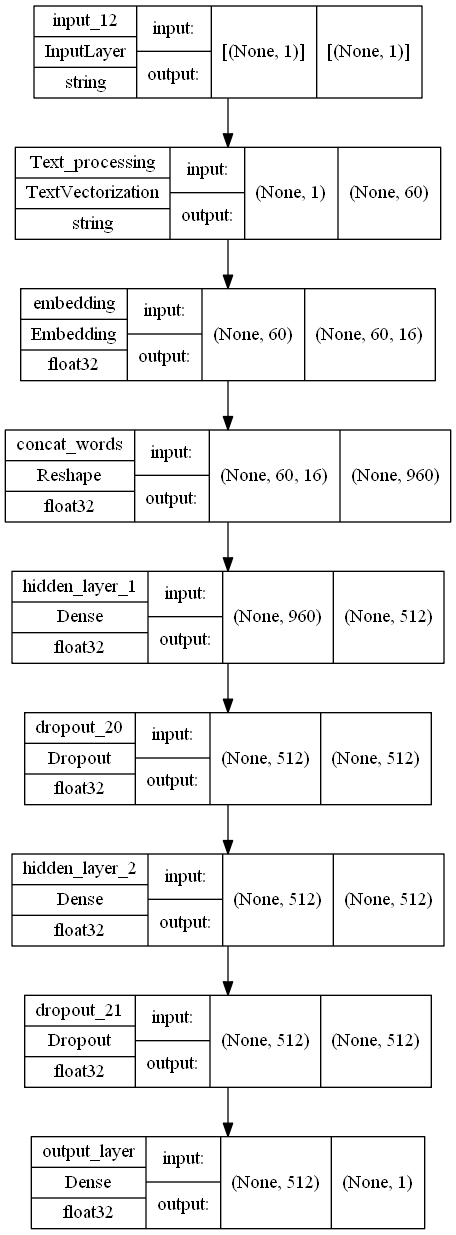

In [280]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [281]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 23s 29ms/step - loss: 90.5793 - val_loss: 8.3676
Epoch 2/20
750/750 [==============================] - 22s 29ms/step - loss: 24.3693 - val_loss: 29.4323
Epoch 3/20
750/750 [==============================] - 20s 26ms/step - loss: 23.8379 - val_loss: 6.7966
Epoch 4/20
750/750 [==============================] - 22s 29ms/step - loss: 23.0797 - val_loss: 6.7206
Epoch 5/20
750/750 [==============================] - 19s 26ms/step - loss: 23.6308 - val_loss: 6.1210
Epoch 6/20
750/750 [==============================] - 19s 25ms/step - loss: 22.2192 - val_loss: 6.3057
Epoch 7/20
750/750 [==============================] - 19s 26ms/step - loss: 23.3905 - val_loss: 6.6631
Epoch 8/20
750/750 [==============================] - 19s 25ms/step - loss: 21.3929 - val_loss: 6.5795
Epoch 9/20
750/750 [==============================] - 19s 25ms/step - loss: 20.6830 - val_loss: 9.1873
Wall time: 3min 2s


In [285]:
test_data['NN_desc_concat'] = model.predict(test_data[text_col])

In [286]:
calc_prediction_quality(test_data, 'NN_desc_concat', target_col)

MSE    6.120978
MAE    1.908829
R2     0.363486
dtype: float64

In [287]:
b7_stats = calc_prediction_quality(test_data, 'NN_desc_concat', 'points')
b7_stats

MSE    6.120978
MAE    1.908829
R2     0.363486
dtype: float64

In [206]:
# using tanh as activation function - Got 9.4
#calc_prediction_quality(test_data, 'dnn_prediction', target_col)

In [207]:
###RNN 
### look at tensorflow text classification documintation 


In [260]:
from keras.layers import LSTM,Bidirectional


In [291]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    #GlobalAveragePooling1D(),
    Bidirectional(LSTM(64)),
    #LSTM(units=128,activation='relu',name='hidden_layer_0'),
    Dense(512, activation='relu', name='hidden_layer_1'),
    Dropout(0.2),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [292]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              41472     
 nal)                                                            
                                                                 
 hidden_layer_1 (Dense)      (None, 512)               66048     
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)             

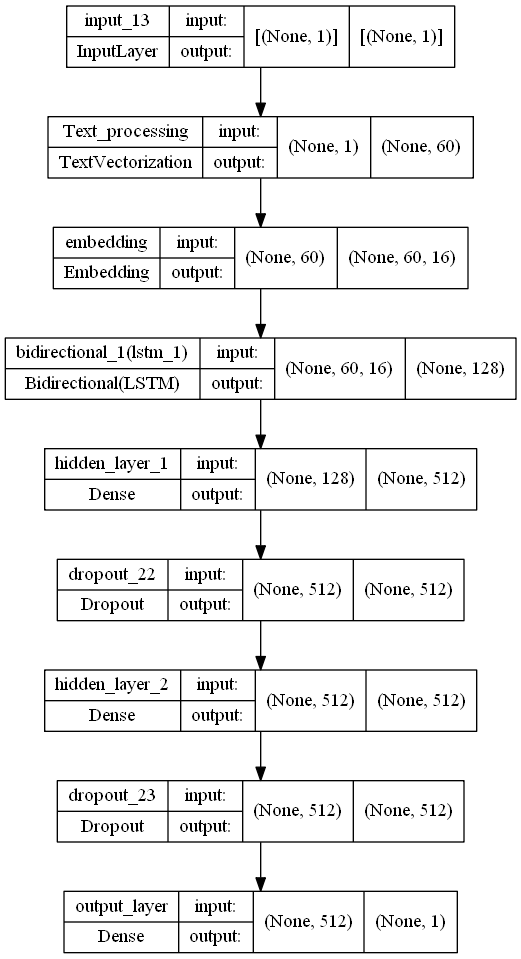

In [293]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [294]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_squared_error')

In [295]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 169s 219ms/step - loss: 180.3428 - val_loss: 5.1609
Epoch 2/20
750/750 [==============================] - 165s 220ms/step - loss: 16.6911 - val_loss: 3.1864
Epoch 3/20
750/750 [==============================] - 164s 218ms/step - loss: 16.4248 - val_loss: 3.6450
Epoch 4/20
750/750 [==============================] - 166s 221ms/step - loss: 16.4551 - val_loss: 3.2469
Epoch 5/20
750/750 [==============================] - 142s 189ms/step - loss: 16.4472 - val_loss: 3.8550
Epoch 6/20
750/750 [==============================] - 160s 213ms/step - loss: 16.0841 - val_loss: 3.6215
Wall time: 16min 5s


In [296]:
test_data['LSTM'] = model.predict(test_data[text_col])

In [297]:
calc_prediction_quality(test_data, 'LSTM', target_col)

MSE    3.186376
MAE    1.400730
R2     0.668652
dtype: float64

In [298]:
b8_stats = calc_prediction_quality(test_data, 'LSTM', 'points')
b8_stats

MSE    3.186376
MAE    1.400730
R2     0.668652
dtype: float64

In [299]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,b4_stats,b5_stats,b6_stats,b7_stats,b8_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','Logistic_regression_BOW','Logistic_regression_BOW_and_features','Simple_NN_training_embedding','Simple_NN_training_embedding_concatonating_words','LSTM'])
all_compared.sort_values(by='MSE',ascending=True)

MSE       MAE        R2
Simple_NN_training_embedding                      2.815833  1.314263  0.707184
Logistic_regression_BOW                           2.928836  1.346959  0.695433
Logistic_regression_BOW_and_features              2.931953  1.347717  0.695109
LSTM                                              3.186376  1.400730  0.668652
Simple_NN_training_embedding_concatonating_words  6.120978  1.908829  0.363486
regression_by_xgb                                 6.450496  1.923952  0.329219
baseline_3                                        8.606235  2.374991  0.105046
baseline_2                                        9.139335  2.466153  0.049610
baseline_1                                        9.616438  2.532518 -0.000004

In [276]:
# Why different NN models gives other results? 

In [289]:
# How the embedding works? 
# 1. cutting the description in 60 words ( 95% Of the data)
# 2. each word gets a vector of 16 that shows the relations to other words
# 3. we either averaging all of the words together or vonvatinating them. The averaging gave a better score, why? He even had more trainable parameters to use. Not sure why...


In [290]:
# 4 The NN models had a high variance in results each time we ran the model. how can we overcome it? 

In [ ]:
# In terms of LSTM vs CNN - >the LSTM lets us learn the word embedding better since it has a lasting memory to all the words in the description, and not just the close words